# The aim of this short code is to demonstrate that in the limit of very large size of a neural network the output distribution of data is Gaussian.
We use a very simple forward NN with a single hidden layer.

If we use as input gaussian distributions with Mu=0 and STD=1 and we define the STD of the output layer as STD/hidden_size, then the minimum number of necessary neurons to have a final gaussian distribution is 3 (hidden_size = 3).

In [55]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest
from scipy.stats import norm
from scipy.optimize import curve_fit

In [56]:
# Define the forward function to compute the output of the neural network
# You can choose the activation you prefer
def forward(X,i,activation):
    Z1 = tf.add(tf.matmul(X, W1[:,:,i]), b1[:,i])
    A1 = activation(Z1)
    Z2 = tf.add(tf.matmul(A1, W2[:,:,i]), b2[:,i])
    return Z2

In [57]:
# Define the dimensions of the NN
input_size = 1
hidden_size = 3
output_size = 1
Nboot = 1000

#Define parameters of the Gaussian distribution
STD = 1
Mu = 0

# Initialize the weights and the bias with random number distributed with a gamma function
W1 = tf.Variable(tf.random.normal([input_size, hidden_size, Nboot], mean=Mu, stddev=STD), name='W1')
b1 = tf.Variable(tf.random.normal([hidden_size, Nboot], mean=Mu, stddev=STD), name='b1')
W2 = tf.Variable(tf.random.normal([hidden_size, output_size, Nboot], mean=Mu, stddev=STD/hidden_size), name='W2')
b2 = tf.Variable(tf.random.normal([output_size, Nboot], mean=Mu, stddev=STD), name='b2')


print(b1.numpy()[0,:].shape)
print(W1.numpy().shape)
print(W2.numpy().shape)


# We compute the output for each event for an input
X = tf.constant([[0.5]], dtype=tf.float32)
output_array = []
for i in range (0, Nboot):
    Y = forward(X,i,tf.nn.relu)
    output_array.append(Y.numpy()[0][0])

(1000,)
(1, 3, 1000)
(3, 1, 1000)


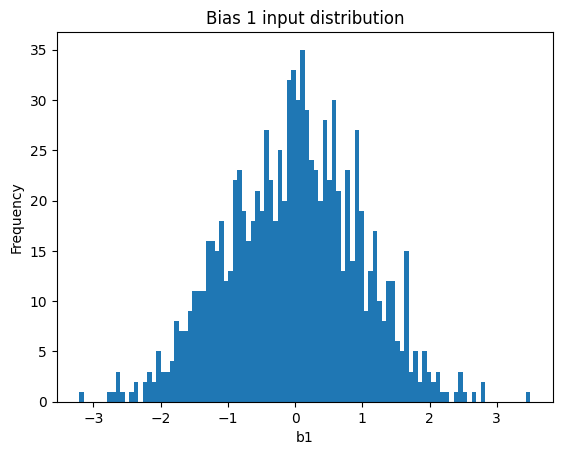

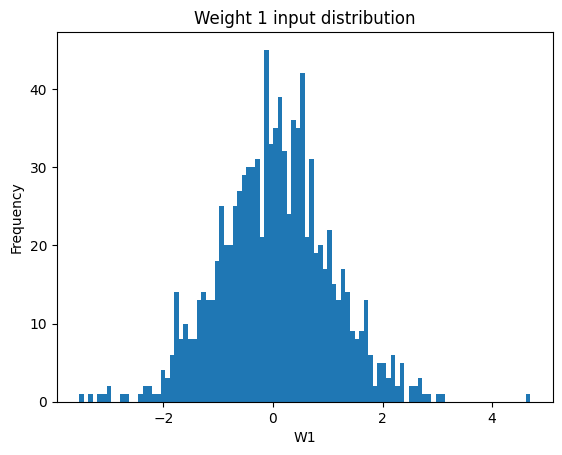

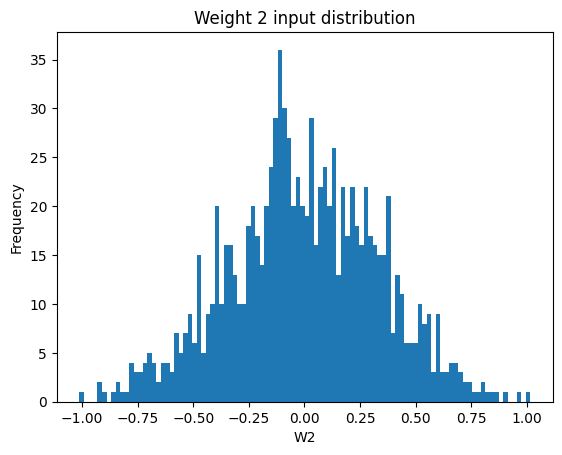

In [58]:
# Print the input distributions of the weights and bias
plt.hist(b1.numpy()[0,:], bins=100)
plt.xlabel('b1')
plt.ylabel('Frequency')
plt.title('Bias 1 input distribution')
plt.show()

plt.clf()

plt.hist(W1.numpy()[0,0,:], bins=100)
plt.xlabel('W1')
plt.ylabel('Frequency')
plt.title('Weight 1 input distribution')
plt.show()

plt.clf()


plt.hist(W2.numpy()[0,0,:], bins=100)
plt.xlabel('W2')
plt.ylabel('Frequency')
plt.title('Weight 2 input distribution')
plt.show()

Data follow a gaussian distribution.


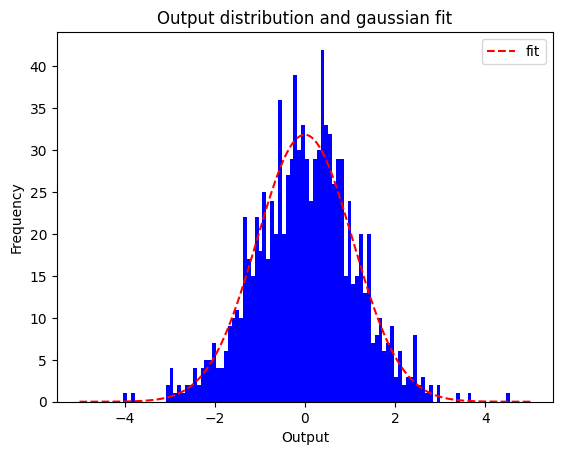

Mean: -0.001970594114321248
Standard deviation: 1.0610586561720832
Amplitude: 31.85798445505466


In [59]:
# Test of the gaussianity
stat, p = normaltest(output_array)

# Print the result of the test
if p < 0.05:
    print("Data don't follow a gaussian distribution.")
else:
    print("Data follow a gaussian distribution.")


# Take parameters of our histogram
counts, bins, _ = plt.hist(output_array, bins=100)


# Define the Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Use curve_fit to fit the histogram to the Gaussian function
p0 = [0, 1, 1]
coeff, var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=p0)

# Plot the histogram and the fitted Gaussian function
x = np.linspace(-5, 5, 1000)
plt.hist(output_array, bins=100, color ='blue')
plt.plot(x, gaussian(x, *coeff), 'r--', label='fit')
plt.legend()
plt.xlabel('Output')
plt.ylabel('Frequency')
plt.title('Output distribution and gaussian fit')
plt.show()

# Print gaussian parameters
print("Mean:", coeff[0])
print("Standard deviation:", coeff[1])
print("Amplitude:", coeff[2])